In [158]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LinearRegression

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [159]:
base = pd.read_csv('../data/adjusted_stats_modeling_base_df.csv')
model = load('../modeling/game_outcome_modeling/saved_models/logistic_regression_av.joblib')
feature_list = ['qb_adjusted_value_home', 'rushing_adjusted_value_home', 'qb_def_adjusted_value_home', 'rush_def_adjusted_value_home', 'special_teams_value_home',
                   'qb_adjusted_value_away', 'rushing_adjusted_value_away', 'qb_def_adjusted_value_away', 'rush_def_adjusted_value_away', 'special_teams_value_away']

In [160]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [161]:
base['home_win_pred'] = win_preds
base['home_win_prob'] = win_probs[:,1]
base['away_win_prob'] = win_probs[:,0]

In [162]:
# Goal here is to find the ideal way to bet on the games after having the model's prediction
# Possible ideas:
# Unsupervised learning - cluster the data by total returns and see what the highest return clusters have in common
# Supervised learning - win probabilities as features, predict how much return based on the given probabilities
# Reinforcement learning - treat this as a game, with the goal to maximize the total returns

# For above methods, going to use the training set predictions. While these predictions are going to be better than 
# the predictions on the test set, by using logistic regression output or a similar low-variance model hopefully the 
# findings on the train set will extrapolate to the test set, and this way it keeps the test set untouched 

analysis_df = base.copy()
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)
analysis_df.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score,away_score,home_qb,away_qb,qb_adjusted_value_home,rushing_adjusted_value_home,qb_rushing_value_pct_home,qb_def_adjusted_value_home,rush_def_adjusted_value_home,special_teams_value_home,qb_adjusted_value_away,rushing_adjusted_value_away,qb_rushing_value_pct_away,qb_def_adjusted_value_away,rush_def_adjusted_value_away,special_teams_value_away,home_win,home_win_pred,home_win_prob,away_win_prob,pred_correct
33,33,2014-09-21,2014,3,REG,New England Patriots,Las Vegas Raiders,16,9,Tom Brady,Derek Carr,0.456221,-0.500777,0.0,2.010295,0.231263,0.937560,0.007547,0.969365,0.0,-0.691465,-0.992021,-0.444697,1,1,0.842271,0.157729,1
36,36,2014-09-21,2014,3,REG,Cleveland Browns,Baltimore Ravens,21,23,Brian Hoyer,Joe Flacco,-0.688197,0.124970,0.0,0.660149,-1.343275,-0.273793,0.652041,-0.098594,0.0,0.629275,-0.397593,0.040821,0,0,0.283371,0.716629,1
37,37,2014-09-21,2014,3,REG,Carolina Panthers,Pittsburgh Steelers,19,37,Cam Newton,Ben Roethlisberger,0.767364,-0.738487,0.0,0.730025,0.510499,0.963767,-0.690944,0.546799,0.0,-0.802556,-0.322210,0.152202,0,1,0.842252,0.157748,0
38,38,2014-09-21,2014,3,REG,Arizona Cardinals,San Francisco 49ers,23,14,Drew Stanton,Colin Kaepernick,-1.157754,0.332257,0.0,-0.737241,0.919733,0.811753,-0.824994,-1.032782,0.0,-0.144545,0.759720,0.278262,1,1,0.586899,0.413101,1
39,39,2014-09-21,2014,3,REG,Buffalo Bills,Los Angeles Chargers,10,22,EJ Manuel,Philip Rivers,0.603547,-2.148207,0.0,1.100186,1.118419,1.432238,1.482525,-0.731489,0.0,0.011487,-0.674026,1.042154,0,0,0.471701,0.528299,1


In [163]:
betting = pd.read_csv('../data/betting_data_cleaned_with_returns.csv')
betting = betting.drop(columns=['Unnamed: 0'])

In [164]:
game_probs = base[['date', 'season', 'week', 'home', 'away', 'home_win', 'home_win_pred', 'home_win_prob', 'away_win_prob']]

In [165]:
game_with_lines = betting.merge(game_probs, left_on=['date', 'home_team', 'away_team'], right_on=['date', 'home', 'away'])

In [166]:
game_with_lines['home_line_advantage'] = game_with_lines.apply(lambda x: x.home_win_prob-x.home_implied_prob, axis=1)
game_with_lines['away_line_advantage'] = game_with_lines.apply(lambda x: x.away_win_prob-x.away_implied_prob, axis=1)
# game_with_lines

In [167]:
game_with_lines

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.670242,0.329758,0.124788,-0.170242
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.539209,0.460791,-0.026009,-0.015399
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.756983,0.243017,0.090316,-0.127354
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.627322,0.372678,-0.094900,0.055218
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.675896,0.324104,-0.115770,0.074104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2014-09-21,Cincinnati Bengals,Tennessee Titans,33,7,40,-265.0,235.0,-6.5,6.5,44.5,under,-26,26,home,0.726027,0.298507,home,37.74,-100.0,37.74,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2014,3,Cincinnati Bengals,Tennessee Titans,1,1,0.888575,0.111425,0.162547,-0.187082
2055,2014-09-21,Cleveland Browns,Baltimore Ravens,21,23,44,111.0,-123.0,2.0,-2.0,43.0,over,2,-2,push,0.473934,0.551570,away,81.30,-100.0,-100.00,81.30,0.00,0.00,0.00,0.00,90.91,-100.00,2014,3,Cleveland Browns,Baltimore Ravens,0,0,0.283371,0.716629,-0.190562,0.165059
2056,2014-09-21,New England Patriots,Las Vegas Raiders,16,9,25,-901.0,704.0,-14.0,14.0,47.5,under,-7,7,away,0.900100,0.124378,home,11.10,-100.0,11.10,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2014,3,New England Patriots,Las Vegas Raiders,1,1,0.842271,0.157729,-0.057829,0.033351
2057,2014-09-21,Philadelphia Eagles,Washington Football Team,37,34,71,-209.0,187.0,-4.0,4.0,50.5,over,-3,3,away,0.676375,0.348432,home,47.85,-100.0,47.85,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2014,3,Philadelphia Eagles,Washington Football Team,1,0,0.348880,0.651120,-0.327495,0.302688


In [168]:
# Supervised learning method

# Going to build a machine learning model to predict home return, and a second model to predict away return
# Then, total returns model will pick whichever expected return is higher, unless there is no positive return

game_with_supervised_preds = game_with_lines.copy()

In [169]:
train_set = game_with_supervised_preds[game_with_supervised_preds.season != 2022]
test_set = game_with_supervised_preds.copy()

In [170]:
# Home return prediction

# Get features, labels for train, val, and test sets

feature_list = ['home_implied_prob', 'away_implied_prob', 'home_win_prob', 'away_win_prob']

train_x = train_set[feature_list].to_numpy()
train_y = train_set.home_return.to_numpy()

# train_x = train_df_shuffled[feature_list].to_numpy()
# train_y = train_df_shuffled.home_win.to_numpy()

test_x = test_set[feature_list]
test_y = test_set.home_return.to_numpy()

In [171]:
model = LinearRegression()
clf = model.fit(train_x, train_y)

game_with_supervised_preds['home_return_pred'] = model.predict(test_x)

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [172]:
# Away return prediction

# Get features, labels for train, val, and test sets

feature_list = ['home_implied_prob', 'away_implied_prob', 'home_win_prob', 'away_win_prob']

train_x = train_set[feature_list].to_numpy()
train_y = train_set.away_return.to_numpy()

# train_x = train_df_shuffled[feature_list].to_numpy()
# train_y = train_df_shuffled.home_win.to_numpy()

test_x = test_set[feature_list]
test_y = test_set.away_return.to_numpy()

In [173]:
model = LinearRegression()
clf = model.fit(train_x, train_y)

game_with_supervised_preds['away_return_pred'] = model.predict(test_x)

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [174]:
game_with_supervised_preds

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,home_return_pred,away_return_pred
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.670242,0.329758,0.124788,-0.170242,-1.420529,-14.462400
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.539209,0.460791,-0.026009,-0.015399,-5.598803,-2.838495
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.756983,0.243017,0.090316,-0.127354,0.833185,-16.513314
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.627322,0.372678,-0.094900,0.055218,-6.071793,-2.537811
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.675896,0.324104,-0.115770,0.074104,-6.683622,-2.939151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2014-09-21,Cincinnati Bengals,Tennessee Titans,33,7,40,-265.0,235.0,-6.5,6.5,44.5,under,-26,26,home,0.726027,0.298507,home,37.74,-100.0,37.74,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2014,3,Cincinnati Bengals,Tennessee Titans,1,1,0.888575,0.111425,0.162547,-0.187082,7.468950,-25.858001
2055,2014-09-21,Cleveland Browns,Baltimore Ravens,21,23,44,111.0,-123.0,2.0,-2.0,43.0,over,2,-2,push,0.473934,0.551570,away,81.30,-100.0,-100.00,81.30,0.00,0.00,0.00,0.00,90.91,-100.00,2014,3,Cleveland Browns,Baltimore Ravens,0,0,0.283371,0.716629,-0.190562,0.165059,-8.135732,12.529244
2056,2014-09-21,New England Patriots,Las Vegas Raiders,16,9,25,-901.0,704.0,-14.0,14.0,47.5,under,-7,7,away,0.900100,0.124378,home,11.10,-100.0,11.10,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2014,3,New England Patriots,Las Vegas Raiders,1,1,0.842271,0.157729,-0.057829,0.033351,1.202256,-13.213637
2057,2014-09-21,Philadelphia Eagles,Washington Football Team,37,34,71,-209.0,187.0,-4.0,4.0,50.5,over,-3,3,away,0.676375,0.348432,home,47.85,-100.0,47.85,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2014,3,Philadelphia Eagles,Washington Football Team,1,0,0.348880,0.651120,-0.327495,0.302688,-10.912580,17.120339


In [183]:
# See how the predictions fared 

# Threshold for random forest needs to be way higher

def get_algo_return(game):
#     min_threshold = 50 
    min_threshold = 5
    if game.home_return_pred > min_threshold and game.home_return_pred > game.away_return_pred:
        return game.home_return
    elif game.away_return_pred > min_threshold and game.away_return_pred > game.home_return_pred:
        return game.away_return
    else:
        return 0
    
game_with_supervised_preds['algo_return'] = game_with_supervised_preds.apply(lambda x: get_algo_return(x), axis=1)

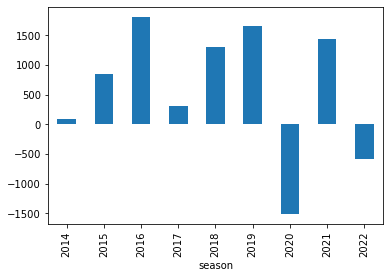

In [184]:
# Look at total returns season by season

game_with_supervised_preds.groupby(by='season').sum()['algo_return'].plot.bar()

In [185]:
game_with_supervised_preds.groupby(by='season').sum()['algo_return']

season
2014      83.42
2015     847.72
2016    1813.91
2017     306.84
2018    1301.48
2019    1660.49
2020   -1516.07
2021    1438.77
2022    -575.25
Name: algo_return, dtype: float64

In [186]:
game_with_supervised_preds.sum()['algo_return']

5361.3099999999995

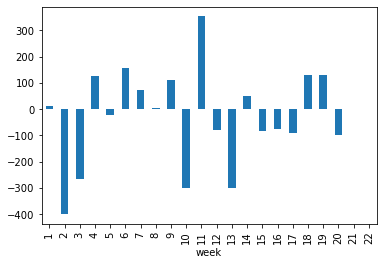

In [187]:
test_season = game_with_supervised_preds[game_with_supervised_preds.season == 2022]
test_season.groupby(by='week').sum()['algo_return'].plot.bar()

In [188]:
test_season[test_season.algo_return!=0]

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,home_return_pred,away_return_pred,algo_return
5,2023-01-21,Kansas City Chiefs,Jacksonville Jaguars,27,20,47,-526.0,400.0,-9.5,9.5,52.0,under,-7,7,away,0.840256,0.200000,home,19.01,-100.0,19.01,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Kansas City Chiefs,Jacksonville Jaguars,1,1,0.584918,0.415082,-0.255337,0.215082,-10.888487,7.023841,-100.00
8,2023-01-15,Minnesota Vikings,New York Giants,24,31,55,-150.0,130.0,-2.5,2.5,48.0,over,7,-7,away,0.600000,0.434783,away,-100.00,130.0,-100.00,130.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,19,Minnesota Vikings,New York Giants,0,0,0.400435,0.599565,-0.199565,0.164783,-9.749794,9.934964,130.00
12,2023-01-08,Green Bay Packers,Detroit Lions,16,20,36,-235.0,195.0,-4.0,4.0,48.0,under,4,-4,away,0.701493,0.338983,away,-100.00,195.0,-100.00,195.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,18,Green Bay Packers,Detroit Lions,0,0,0.405950,0.594050,-0.295543,0.255067,-13.788321,15.140786,195.00
15,2023-01-08,Denver Broncos,Los Angeles Chargers,31,28,59,-280.0,230.0,-6.5,6.5,39.0,over,-3,3,away,0.736842,0.303030,home,35.71,-100.0,35.71,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,18,Denver Broncos,Los Angeles Chargers,1,0,0.428527,0.571473,-0.308315,0.268443,-13.736530,14.956478,-100.00
16,2023-01-08,Indianapolis Colts,Houston Texans,31,32,63,-155.0,135.0,-3.0,3.0,37.5,over,1,-1,away,0.607843,0.425532,away,-100.00,135.0,-100.00,135.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,18,Indianapolis Colts,Houston Texans,0,0,0.446865,0.553135,-0.160978,0.127603,-7.884095,6.278930,135.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022-09-18,Los Angeles Rams,Atlanta Falcons,31,27,58,-500.0,375.0,-10.0,10.0,46.0,over,-4,4,away,0.833333,0.210526,home,20.00,-100.0,20.00,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,2,Los Angeles Rams,Atlanta Falcons,1,0,0.467036,0.532964,-0.366298,0.322438,-15.976878,16.962312,-100.00
226,2022-09-18,Detroit Lions,Washington Football Team,36,27,63,-116.0,-105.0,-1.0,1.0,48.0,over,-9,9,home,0.537037,0.512195,home,86.21,-100.0,86.21,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,2,Detroit Lions,Washington Football Team,1,0,0.429831,0.570169,-0.107207,0.057974,-10.971027,5.736288,-100.00
233,2022-09-11,Arizona Cardinals,Kansas City Chiefs,21,44,65,215.0,-263.0,6.0,-6.0,54.0,over,23,-23,away,0.317460,0.724518,away,38.02,-100.0,-100.00,38.02,90.91,-100.00,-100.00,90.91,90.91,-100.00,2022,1,Arizona Cardinals,Kansas City Chiefs,0,0,0.213310,0.786690,-0.104151,0.062173,-11.056023,12.207071,38.02
235,2022-09-11,Minnesota Vikings,Green Bay Packers,23,7,30,-132.0,110.0,-2.0,2.0,46.5,under,-16,16,home,0.568966,0.476190,home,75.76,-100.0,75.76,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Minnesota Vikings,Green Bay Packers,1,0,0.417185,0.582815,-0.151781,0.106625,-11.159055,7.999475,-100.00


In [189]:
len(test_season[test_season.algo_return!=0])

65

In [193]:
# Reinforcement Learning

# Since reinforcement learning is typically done with an agent learning about its environment, not really sure how 
# it would work here. Is it ok to just use the test set? Or should the agent still learn from the train set?

board = game_with_supervised_preds[['season', 'week', 'home_implied_prob', 'away_implied_prob', 'home_win_prob', 'away_win_prob', 'home_return', 'away_return']]
train_board = board[board.season != 2022]

In [199]:
# Variables to store important information

# Amount of money, if this dips below 0 then game is over. Goal is for the agent to maximize this amount
starting_bankroll = 1000

# Wagerable amounts, for now 0 to 100 in increments of 10 
possible_wagers = np.arange(0, 101, 10)

# Timeline of money in bankroll, stored in list
bankroll_timeline = [starting_bankroll]

In [ ]:
def 